Accessing the NIST/ARPA-E Database of Novel and Emerging Adsorbent Material API
===============================================================================

The NIST Database of Novel and Emerging Materials
([DNEM](https://adsorption.nist.gov/isodb/index.php#home)) provides an
Application Programming Interface (API) that allows you to search for
and access data using a computer program. This tutorial is specifically
aimed at accessing the API using Python 3, but documentation for the API
can be found [here](https://adsorption.nist.gov/isodb/index.php#apis).

Quick Overview
--------------

The API can access bibliographic information (containing DOI, title,
material and gas types, *etc*) based on user-defined searches (*e.g.* by
gas type or framework type) or by specific entry names (*i.e.* search by
DOI \[digital object identifier\] or title, to extract a single entry).
Isotherm data can be extracted by filename (which are reported in the
linked bibliographic entry).

Getting started
---------------

To use Python to access the API, we require the
[requests](https://pypi.org/project/requests/) package to be
installed.[1] To check that everything is working, try the following
within a python (Jupyter or Ipython) session:

[1] If not, you may need to use `pip install requests` or
`conda install requests` depending on your Python version.

In [1]:
import requests

info = requests.get("https://adsorption.nist.gov/api/version.json")
print('API Version: {}'.format(info.json()['version']))

API Version: 3.14269


This should have run and printed a version number as output (3.4657 at
the time of writing).

What just happened?  
The code above loads the `requests` module, and then uses it’s `.get`
method to contact the NIST API, and ask it for the current API version
(../api/version.json). The information returned is stored in the `info`
variable, which is then processed to find the version number (we will go
through this in more detail later).

Getting bibliographic information
---------------------------------

The API provides a number of ways to search for information records:

### Search by (part of the) title or DOI for a single record

In [2]:
# By title or DOI
title = requests.get('https://adsorption.nist.gov/api/biblio/Grand Canonical Transition-Matrix Monte Carlo.json')
DOI = requests.get('https://adsorption.nist.gov/isodb/api/biblio/10.1021/Jp400480q.json')

print('Searched by title: ',title.json()[0]['title'])
print('Searched by DOI: ',DOI.json()[0]['title'])

Searched by title:  Use of the Grand Canonical Transition-Matrix Monte Carlo Method to Model Gas Adsorption in Porous Materials
Searched by DOI:  Use of the Grand Canonical Transition-Matrix Monte Carlo Method to Model Gas Adsorption in Porous Materials


### Search by adsorbent material name

In [3]:
all_CuBTC_MOFs = requests.get('https://adsorption.nist.gov/isodb/api/biblio-material/CuBTC.json')

print('There are {} CuBTC MOF entries in the database'.format(len(all_CuBTC_MOFs.json())))

There are 353 CuBTC MOF entries in the database


### Search by adsorbate gas

In [4]:
N2_adsorbate_records = requests.get('https://adsorption.nist.gov/isodb/api/biblio-gas/C6H12.json')

print ('Search found {} records containing C6H12 as an adsorbate'.format(len(N2_adsorbate_records.json())))

Search found 39 records containing C6H12 as an adsorbate


Note that these methods can all return multiple records, *e.g.* by
matching just part of the title.

### A warning!

Be aware that the search by material name or gas is not necessarily
unique. Consider example (3) above; C<sub>6</sub>H<sub>12</sub> could
correpond to either cyclohexane *or* hex-1-ene (and a few others), and
both results are returned (in fact, there are currently 35 entries for
cyclohexane, and 3 for hexene).
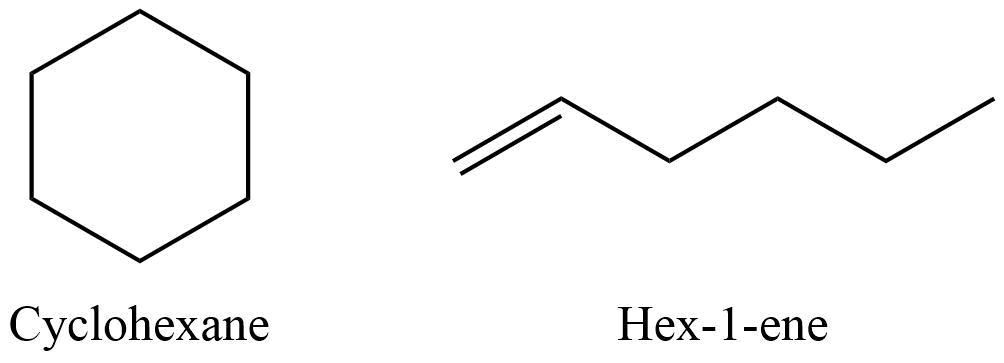  
For this reason, the database can be searched using the unique
‘InChIKey’ representation (for gases) or ‘hashkey’ (for materials).
These can be found using the API itself and then used for further
searches. For instance, if we knew we actually wanted cyclohexane in
(3), but had no idea what the InChIKey was:

In [5]:
# First, search to get the unique key
cyclohexane = requests.get('https://adsorption.nist.gov/isodb/api/gas/cyclohexane.json')
cyclohexane_inchikey = cyclohexane.json()['InChIKey']

# Second, use that to search the database to give reliable results
cyclohexane_records = requests.get('https://adsorption.nist.gov/isodb/api/biblio-gas/{}.json'.format(cyclohexane_inchikey))

print ('There are {} records containing cyclohexane'.format(len(cyclohexane_records.json())))

There are 37 records containing cyclohexane


We have searched by name for the unique key, and then use that to
guarentee that we extract the results we want. The database contains a
list of synonyms for different gases, so searching for Hex-1-ene will
give the same InChIKey as if you searched for 1-hexene or
1-C<sub>6</sub>H<sub>12</sub>.

You might want to search for the unique identifier for an adsorbant
material (hashkey), for for instance if the same material is known by
two different names (*e.g.* MOF-5 and IRMOF-1). If so, use the following
API request:

In [6]:
MOF5 = requests.get('https://adsorption.nist.gov/matdb/api/material/mof-5.json')
print ('Returned information:')
print (MOF5.text)

print ('\nThe hashkey for MOF-5 (or IRMOF-1) is', MOF5.json()['hashkey'])

Returned information:
{
    "hashkey": "NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb",
    "name": "IRMOF-1",
    "formula": "",
    "synonyms": [
        "MOF-5"
    ],
    "External_Resources": [
        {
            "name": "CSD",
            "values": [
                "SAHYIK"
            ]
        }
    ]
}

The hashkey for MOF-5 (or IRMOF-1) is NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb


Getting Isotherm Data
---------------------

The API methods discussed so far allow you to extract database items by
gases or materials, but only return bibliographic information such as
publication name, year, authors etc. Examining the entry we extracted in
part (1) we can see that the isotherm information is not present,
instead there is a reference to a filename(s):

In [7]:
# Using `title` which we created earlier:
print(title.text)

[
    {
        "DOI": "10.1021/Jp400480q",
        "title": "Use of the Grand Canonical Transition-Matrix Monte Carlo Method to Model Gas Adsorption in Porous Materials",
        "journal": "The Journal of Physical Chemistry C",
        "year": 2013,
        "authors": [
            "Daniel W. Siderius",
            "Vincent K. Shen"
        ],
        "categories": [
            "sim"
        ],
        "adsorbents": [
            {
                "hashkey": "NIST-MATDB-47dadc99a0da13b9e9bb3032468ecbdf",
                "name": "MWCNT"
            },
            {
                "hashkey": "NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b",
                "name": "ZIF-8"
            },
            {
                "hashkey": "NIST-MATDB-bacc6813c3ba57be113baedb7483f6ba",
                "name": "Solid CO2"
            }
        ],
        "adsorbentMaterial": [
            "MWCNT",
            "ZIF-8",
            "Solid CO2"
        ],
        "adsorbates": [
            {
          

from this output we can see that this single entry contains information
for **two** adsorbate gases (carbon dioxide and argon) and **three**
materials (MWCNT, ZIF-8 and solid CO<sub>2</sub>), and the resulting
isotherms are found in the files ‘10.1021Jp400480q.IsothermX’ for X = 1
to 8. If we want to get the actual isotherm data, we need to use another
part of the API (note the slight difference in http address to before):

In [8]:
# First, extract the isotherm file names from the bibliographic entry
isotherm_files = title.json()[0]['isotherms']

# Then, if we wanted to get the data for the second file
isotherm2 = requests.get('https://adsorption.nist.gov/isodb/api/isotherm/{}.json'.format(isotherm_files[1]['filename']))        # Remember that Python starts counting from 0, so the second file is number 1 in the list...

print ('The available information in the isotherm file is:')
for key in isotherm2.json().keys():
    print('\t',key)


The available information in the isotherm file is:
	 filename
	 DOI
	 articleSource
	 date
	 digitizer
	 adsorbent
	 adsorbates
	 category
	 temperature
	 tabular_data
	 isotherm_type
	 adsorptionUnits
	 pressureUnits
	 compositionType
	 concentrationUnits
	 isotherm_data


The isotherm files provide much more than pressure/adsorption data,
including details of the material and gas(es) involved, the units the
data are reported in and the measurement temperature, amongst others.

In order to plot a simple isotherm curve, we can make use of the
`matplotlib` library (if you are using an ipython terminal, you may have
already imported this).

Text(0, 0.5, 'Total Adsorption (kmol/m3)')

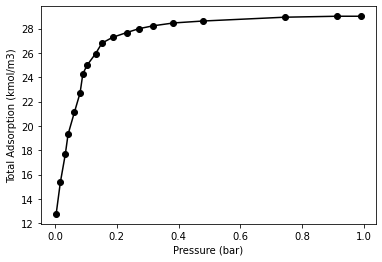

In [9]:
import matplotlib.pyplot as plt

# Convert our json output (from requests) into python dictionaries
iso = isotherm2.json()

# The following looks a bit complicated, but is a quick way to convert the nested dictionaries into a list of numbers for plotting
pressures = [i['pressure'] for i in iso['isotherm_data']]
adsorption = [j['total_adsorption'] for j in iso['isotherm_data']]

plt.plot(pressures, adsorption, marker='o', linestyle='-', c='k', label='Isotherm2')
plt.xlabel('Pressure ({})'.format(iso['pressureUnits']))
plt.ylabel('Total Adsorption ({})'.format(iso['adsorptionUnits']))

# If you want to save the resulting graph, uncomment the following line
# plt.savefig('FILENAME.png')

As you may have guessed, there is one big drawback to this approach; if
a bibliographic entry contains more than one set of isotherm data there
is no way (from the bibliographic info) to determine which isotherm file
corresponds to which gas/material combination! This seems to be an
oversight from the people at NIST, but we can get round it using a bit
more Python. For instance, if we wanted to find all the ZIF-8 and
CO<sub>2</sub> isotherm files from this same record, we could construct
the following loop to check:

In [10]:
for file in title.json()[0]['isotherms']:
    current_isotherm = requests.get('https://adsorption.nist.gov/isodb/api/isotherm/{}.json'.format(file['filename'])).json()
    # Check if the current file contains ZIF-8 and CO2
    if (current_isotherm['adsorbent']['name'] == 'ZIF-8') and ('carbon dioxide' in [i['name'].lower() for i in current_isotherm['adsorbates']]):
        print ( file['filename'], 'contains ZIF-8 and CO2')
    

10.1021Jp400480q.Isotherm8 contains ZIF-8 and CO2


This loop will return the isotherm filenames, which you could then use
to extract the data and check for temperature, units etc. If you find
that you need to extract a lot of data repeatedly, it may be better to
write a Python function that can filter it for you. The following
example takes one or more bibliographic entries as input, loops through
their isotherm files and checks to see if the adsorbent/adsorbate
combination matches those specified. The output from the function is a
Python dictionary of matching isotherm filenames with the corresponding
isotherm file content.

In [11]:
def filter_isotherms(bibliographic_entry, adsorbent, adsorbate):
    ''' Return a dictionary of isotherms matching the given adsorbent and adsorbate, with the isotherm data included '''
    
    # Check if the bibliographic entry is a dictionary or a list of dictionaries (this assumes that the .json() method has already been run on the requests result
    # This approach allows bibliographic_entry to be either one entry, or a list of entries to check
    if isinstance(bibliographic_entry, dict):
        input_data = [bibliographic_entry]
    elif isinstance(bibliographic_entry, list):
        input_data = bibliographic_entry
    
    matching_files = {}
    
    for file in input_data:
        for iso in file['isotherms']:
            current_isotherm = requests.get('https://adsorption.nist.gov/isodb/api/isotherm/{}.json'.format(iso['filename'])).json()
            # Check if the current file contains adsorbate and adsorbent
            if (current_isotherm['adsorbent']['name'].lower() == adsorbent.lower()) and (adsorbate.lower() in [i['name'].lower() for i in current_isotherm['adsorbates']]):
                matching_files[iso['filename']] = current_isotherm
            
    return matching_files

This approach avoids having to make too many API requests, which are
inherently quite slow. To use the function, you must specify the input
bibliographic data, adsorbent name and adsorbate gas:

In [12]:
MWCNT_data = filter_isotherms(title.json(), 'MWCNT', 'argon')

for dat in MWCNT_data:
    print (dat, 'was collected at', MWCNT_data[dat]['temperature'], 'K')


10.1021Jp400480q.Isotherm1 was collected at 87 K
10.1021Jp400480q.Isotherm2 was collected at 87 K
10.1021Jp400480q.Isotherm3 was collected at 87 K
10.1021Jp400480q.Isotherm4 was collected at 87 K
10.1021Jp400480q.Isotherm5 was collected at 87 K
10.1021Jp400480q.Isotherm6 was collected at 87 K
10.1021Jp400480q.Isotherm7 was collected at 87 K


Handling Data with Pandas
-------------------------

If you have a number of isotherm curves in a dictionary, it quickly
becomes difficult to process all the data to ensure compatibility
(*i.e.* the same units) and to easily plot the data. One solution to
this is to use the [Pandas](https://pandas.pydata.org/) package, which
adds easy-to-use data structures and analysis tools for manipulating
data (think Excel, but more flexible).

The main way of storing data in Pandas is in a `DataFrame` object, so
the first step is to manipulate our data into this format. For many data
formats (such as nested dictionaries of information) this is as simple
as typing `pd.DataFrame(source_of_data)`, but in our case (for the
isotherm data) we need to do a bit more processing:

In [13]:
import pandas as pd

def isotherm_to_dataframe(isotherm_file):
    ''' Convert the information in an isotherm file into a pandas DataFrame '''
    
    # First, extract the isotherm_data. You could just use 'pressure' and 'total_adsorption' at this point, but
    # we want to get the partial adsorbances of different gases (if more than one gas is present)
    data = pd.DataFrame(isotherm_file['isotherm_data'])
    
    # Loop over the different gases in the isotherm, checking that we have
    # extracted the correct data
    for i, gas in enumerate(isotherm_file['adsorbates']):
        gas_name = gas['name']
        gas_data = pd.DataFrame( list(data['species_data'].apply(lambda x: x[i])) )     # Quick way to get the i'th species, and return a DataFrame for it
        
        # Check that we are looking at the correct gas (should be, as long as the database is constructed sensibly)
        assert (gas_data['InChIKey'] == gas['InChIKey']).all()
        
        # Pandas lets us easily add a new column to our data table, making sure the rows are aligned properly
        data[gas_name + '_adsorption'] = gas_data['adsorption']
        data[gas_name + '_composition'] = gas_data['composition']
        
    return data.drop('species_data', axis=1)

This function will return a pandas DataFrame containing all the
adsorption information from the isotherm file. Unfortunately there is no
way to keep the metadata (temperature, units etc) with the resulting
data, so the best way is to add the new DataFrame object back in to the
original isotherm information as a new ‘key’. [1]

[1] Don’t worry, you can’t break the NIST database! You will just be
modifying your local version of the data.

In [14]:

isotherm = MWCNT_data['10.1021Jp400480q.Isotherm1']

isotherm['dataframe'] = isotherm_to_dataframe( MWCNT_data['10.1021Jp400480q.Isotherm1'] )

# Print the first few rows of the dataframe
isotherm['dataframe'].head()

pressure  total_adsorption  Argon_adsorption  Argon_composition
0  0.044059           6.31711           6.31711                  1
1  0.078576           7.26249           7.26249                  1
2  0.108505           8.28725           8.28725                  1
3  0.140716           9.07480           9.07480                  1
4  0.161425           9.62624           9.62624                  1

As you can see above, pandas displays the data in a clear table format.
It can also be used for some very powerful data manipulation, however.
For example, imagine that we wanted to convert the total adsorption to
different units (for the current isotherm it is in kmol m<sup>-3</sup>,
but suppose we wanted it in mol cm<sup>-3</sup>. We can just add a new
column based on the old one:

In [15]:
isotherm['dataframe']['total_adsorption_mol/cm3'] = isotherm['dataframe']['total_adsorption'] * 0.001
isotherm['dataframe'].head()

pressure  total_adsorption  Argon_adsorption  Argon_composition  \
0  0.044059           6.31711           6.31711                  1   
1  0.078576           7.26249           7.26249                  1   
2  0.108505           8.28725           8.28725                  1   
3  0.140716           9.07480           9.07480                  1   
4  0.161425           9.62624           9.62624                  1   

   total_adsorption_mol/cm3  
0                  0.006317  
1                  0.007262  
2                  0.008287  
3                  0.009075  
4                  0.009626

In the same way, we can perform arithmetic by combining columns (*e.g.*
`'total_adsorption' - 'Argon_adsorption'`, which in this case should be
a column of zeros). We can also extract individual values from the table
using `.loc`, or use some in-built methods in Pandas:

In [16]:
# Find the change in adsorption from the minimum value
isotherm['dataframe']['total_adsorption - minimum adsorption'] = isotherm['dataframe']['total_adsorption'] - isotherm['dataframe'].loc[0,'total_adsorption']
# An alternative (perhaps better) way to do this would be to explicitly use the minimum:
#isotherm['dataframe']['total_adsorption - minimum adsorption'] = isotherm['dataframe']['total_adsorption'] - isotherm['dataframe']['total_adsorption'].min()

# Find the change in adsorption at each point
isotherm['dataframe']['delta(abs)'] = isotherm['dataframe']['total_adsorption'].diff()

isotherm['dataframe'].head()

pressure  total_adsorption  Argon_adsorption  Argon_composition  \
0  0.044059           6.31711           6.31711                  1   
1  0.078576           7.26249           7.26249                  1   
2  0.108505           8.28725           8.28725                  1   
3  0.140716           9.07480           9.07480                  1   
4  0.161425           9.62624           9.62624                  1   

   total_adsorption_mol/cm3  total_adsorption - minimum adsorption  delta(abs)  
0                  0.006317                                0.00000         NaN  
1                  0.007262                                0.94538     0.94538  
2                  0.008287                                1.97014     1.02476  
3                  0.009075                                2.75769     0.78755  
4                  0.009626                                3.30913     0.55144

### Plotting with Pandas

Pandas also provides some convenient plotting functions, which make it
really easy to plot graphs. At its simplest:

<AxesSubplot:xlabel='pressure'>

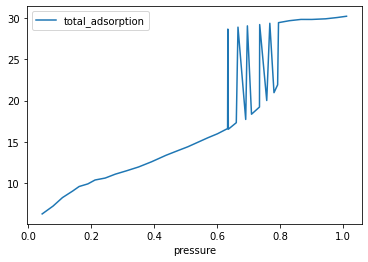

In [17]:
isotherm['dataframe'].plot(x='pressure', y='total_adsorption')

But we can do much, much more…

Text(0, 0.5, 'Adsorption (kmol/m3)')

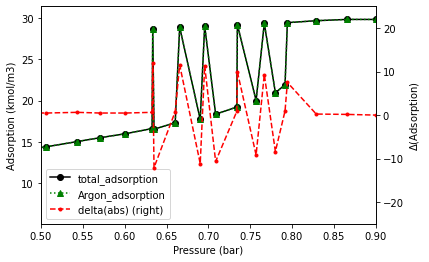

In [18]:
fig, axes = plt.subplots(1,1)

isotherm['dataframe'][['pressure','total_adsorption','Argon_adsorption','delta(abs)']].plot(
    x='pressure',
    secondary_y='delta(abs)',
    ax=axes,
    style=['ko-','g^:','r.--'],
    label=['Total','Argon','$\Delta(total)$'],
)

axes.set_xlim(0.5,0.9)
axes.right_ax.set_ylim(-25,25)
axes.right_ax.set_ylabel('$\Delta(\mathrm{Adsorption})$')

axes.set_xlabel('Pressure ({})'.format(isotherm['pressureUnits']))
axes.set_ylabel('Adsorption ({})'.format(isotherm['adsorptionUnits']))

### Saving Pandas data

If you find you need to save the output from Pandas, it is relatively
easy to write the text into a .csv file which could be read again in the
future:

In [19]:
isotherm['dataframe'].to_csv('CSVfile.csv', index=False)

read_data = pd.read_csv('CSVfile.csv')

read_data.head()

pressure  total_adsorption  Argon_adsorption  Argon_composition  \
0  0.044059           6.31711           6.31711                  1   
1  0.078576           7.26249           7.26249                  1   
2  0.108505           8.28725           8.28725                  1   
3  0.140716           9.07480           9.07480                  1   
4  0.161425           9.62624           9.62624                  1   

   total_adsorption_mol/cm3  total_adsorption - minimum adsorption  delta(abs)  
0                  0.006317                                0.00000         NaN  
1                  0.007262                                0.94538     0.94538  
2                  0.008287                                1.97014     1.02476  
3                  0.009075                                2.75769     0.78755  
4                  0.009626                                3.30913     0.55144

Unfortunately there is now convenient way to store the header
information (*e.g.* units) in the .csv directly using Pandas. Perhaps
the simplest solution (at the expense of being able to view the data
with *e.g.* Excel) is to convert the whole lot into a JSON string (see
below) and save that to disk. To do this, we need to write a couple of
functions which do the encoding/decoding:

In [20]:
def encode_json(obj):
    if isinstance(obj, pd.DataFrame):
        return obj.to_json()
    return obj.__dict__

def decode_json(dct):
    if 'dataframe' in dct:
        dct['dataframe'] = pd.read_json(dct['dataframe'])
        return dct
    else:
        return dct

To actually save isotherm data, it is then a case of doing the following
(note, we have to import the json module from Python):

Isotherm for Argon in MWCNT measured at 87 K:


<AxesSubplot:xlabel='pressure'>

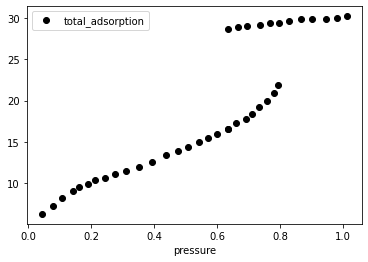

In [21]:
import json

# Write to file `FILENAME.json`
with open('FILENAME.json', 'w') as file:
    json.dump(isotherm, file, default=encode_json)
    
# Read the file back in
with open('FILENAME.json', 'r') as file:
    read_data = json.load(file, object_hook = decode_json)
    

print ('Isotherm for {} in {} measured at {} K:'.format(read_data['adsorbates'][0]['name'], 
                                                       read_data['adsorbent']['name'],
                                                       read_data['temperature']))

read_data['dataframe'].plot(x='pressure', y='total_adsorption', style='ko')

**NOTE**: In the decoding process, the order of the dictionary objects
(and the pandas dataframe) can get scrambled (*i.e.* rows swapped). This
doesn’t matter for the dictionary entries (which you should always
access by their key) but you may want to sort the dataframe so that
plots look better. Compare the following:

Text(0, 0.5, 'Total Adsorption')

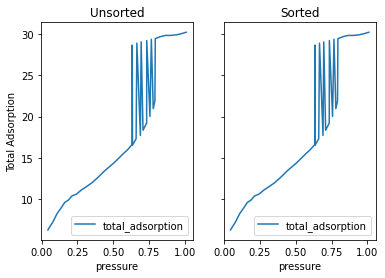

In [22]:

with open('FILENAME.json', 'r') as file:
    sorted = json.load(file, object_hook = decode_json)

sorted['dataframe'].sort_values(by='pressure', inplace=True)

fig, axes = plt.subplots(1,2, sharey=True)

a = axes[0]

read_data['dataframe'].plot(x='pressure', y='total_adsorption', ax=axes[0])
axes[0].set_title('Unsorted')

sorted['dataframe'].plot(x='pressure', y='total_adsorption', ax=axes[1])
axes[1].set_title('Sorted')

axes[0].set_ylabel('Total Adsorption')


Where to go from here
---------------------

Hopefully this tutorial has shown you the main ways of accessing and
processing data from the NIST website. You can combine some of these
commands and write your own to perform some really quite powerful data
manipulations. Once the data is in Pandas format, you have access to a
lot of tools I haven’t mentioned for performing calculations, fits to
the data etc. For more details about pandas and how to acheive certain
things, see [the
documentation](https://pandas.pydata.org/pandas-docs/stable/) (which is
really good, and gives loads of examples)!

Plotting with pandas relies on the matplotlib library, which is also
very powerful and has a really good
[gallery](https://matplotlib.org/gallery/index.html) of example plots if
you’re looking for inspiration or how to achieve something.

If all else fails, feel free to ask myself or Claire!

Too much detail about JSON
--------------------------

Throughout this tutorial, we have extracted data from the web using
requests, and then somehow turned it into something useful. In the
middle of this process there is a little method called `.json()` which
seems to have done some magic. Here we try to explain a bit more about
the output from requests.

JSON (Javascript Object Notation) is a way of passing information around
the internet, by giving it a logical structure that can be expressed as
text. If you have played around with the output from `requests` you will
have noticed that it contains quite a lot of information (try
`dir(title)` to see what is available). The most useful parts are

`title.status_code`  
This tells you whether the request was successful or not (should = 200
for a good response). Ideally your code should check that the API has
responded correctly

`title.text`  
This returns the content of the API request as text, which can be useful
for printing/debugging (*i.e.* \`print(title.text)

`title.json()`  
This is the most useful command, and turns the text from the API into
something Python-readable (a combination of dictionaries and lists). As
shown in the previous examples, once you have converted the output to
JSON, you can extract items from a list (*e.g.* `title.json()[0]`) or
retrieve values from a dictionary based on the key (*e.g.*
`isotherm['adsorbent']['name']`)

A general rule is to always run the `.json()` method on the output from
requests, unless you know you don’t need to! If you run into problems
like:

In [23]:
isotherm[0]

KeyError: 0

or

In [24]:
title.json()['filename']

TypeError: list indices must be integers or slices, not str

check whether you are handling a list or a dictionary (if unsure, check
with *e.g.* `type(isotherm)`)